In [8]:
import io
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torchvision
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
from flask import Flask, jsonify, request

In [9]:
import torchvision.transforms as transforms

In [110]:
def get_model_instance_segmentation(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

model = get_model_instance_segmentation(4)

In [112]:
torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [10]:
def get_model_instance_segmentation(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

model = get_model_instance_segmentation(4)
if torch.cuda.is_available():
    device = torch.device('cuda')
    model.to(device)
    model.load_state_dict(torch.load('fasterrcnn_05.pt'))
else:
    device = torch.device('cpu')
    model.to(device)
    model.load_state_dict(torch.load('fasterrcnn_05.pt', map_location=device))

model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [102]:
def fasterrcnn():

    print('start loading model')
    model = get_model_instance_segmentation(4)
    print('finished loading model')

    if torch.cuda.is_available():
        device = torch.device('cuda')
        model.to(device)
        model.load_state_dict(torch.load('fasterrcnn_05.pt'))
    else:
        device = torch.device('cpu')
        model.to(device)
        model.load_state_dict(torch.load('fasterrcnn_05.pt', map_location=device))

    print('finished loading weight')

    model.eval()
    
    return model 

In [11]:
def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    #plt.show()
    return fig, ax


# change 1 image to tensor
def transform_image(image_bytes):
    transform = transforms.Compose([transforms.ToTensor()])
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    return transform(image).unsqueeze(0)


def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [33]:
with open("maksssksksss140.png", 'rb') as f:
    print(type(f))

<class '_io.BufferedReader'>


In [12]:
with open("maksssksksss140.png", 'rb') as f:
    image_bytes = f.read()
    tensor = transform_image(image_bytes=image_bytes)
    

In [13]:
tensor = tensor.to(device)

In [14]:
tensor.shape

torch.Size([1, 3, 267, 400])

In [14]:
%time
output = make_prediction(model, tensor, 0.5)

Wall time: 0 ns


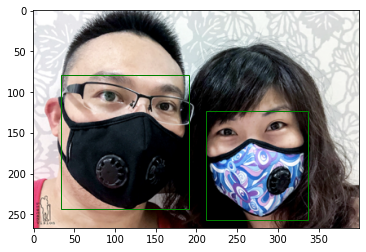

In [15]:
_fig, _out = plot_image_from_output(tensor[0], output[0])

In [19]:
import numpy as np

In [21]:
fig = _fig

In [23]:
fig.canvas.draw()

In [24]:
data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

<ipython-input-24-371608393009>:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')


In [31]:
image_file = Image.fromarray(data)

In [32]:
img_io = io.BytesIO()

In [34]:
image_file.save(img_io, 'PNG', quality = 70)

In [36]:
img_io.seek(0)

0

In [62]:
import requests

headers = {
    'accept': 'images/*',
    'Content-Type': 'multipart/form-data',
}

files = {
    'base_image': open('maksssksksss14.png', 'rb'),
    'style_image': open('mask1.jfif', 'rb'),
}

response = requests.post('https://master-ainize-run-style-transfer-ainize-team.endpoint.ainize.ai/transfer', headers=headers, files=files)


In [64]:
response


<Response [400]>

In [1]:
import requests

# resp = requests.post("https://master-face-mask-detection-api-sds-tony.endpoint.ainize.ai",
#                      data={"file": open('maksssksksss14.png','rb')})

In [ ]:
resp.content

In [93]:
requests.get("http://127.0.0.1:5000/transfer")

<Response [405]>

In [91]:
requests.get("http://127.0.0.1:8000/trasfer")

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [99]:
resp = requests.post("http://127.0.0.1:5000/transfer",
                     files={"base_image": open('maksssksksss140.png','rb'),
                           "style_image": open('maksssksksss14.png','rb')})

In [113]:
resp = requests.post("http://127.0.0.1:5000/predict",
                     files={"file": open('maksssksksss140.png','rb')})

In [125]:
resp = requests.post("http://127.0.0.1:80/predict",
                     files={"file": open('mask1.jfif','rb')})

In [115]:
resp.content

b'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">\n<title>500 Internal Server Error</title>\n<h1>Internal Server Error</h1>\n<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>\n'

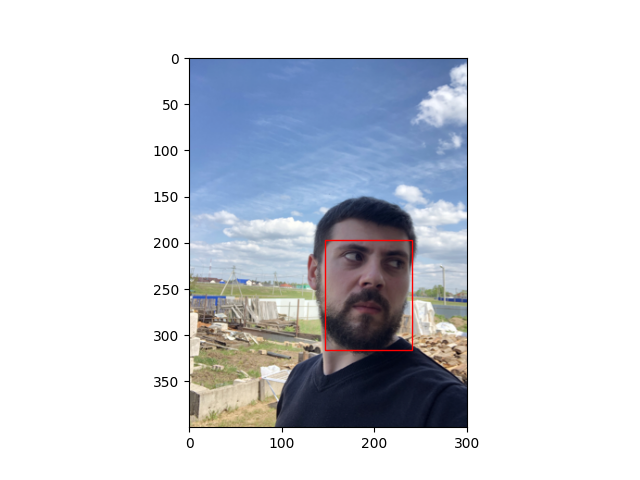

In [124]:
Image.open(io.BytesIO(resp.content)).convert("RGB")

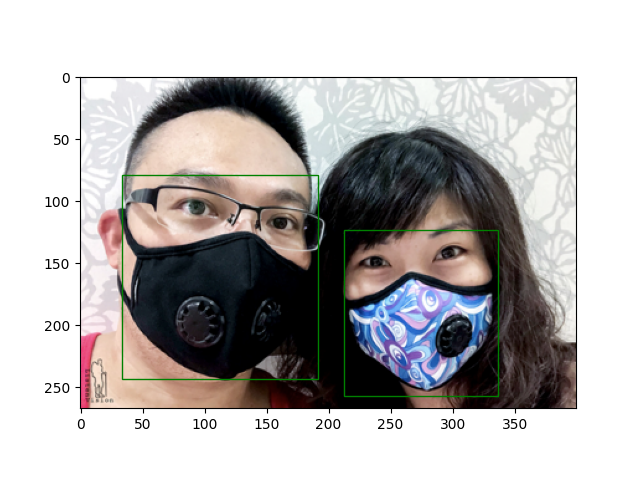

In [57]:
Image.open(io.BytesIO(resp.content)).convert("RGB")

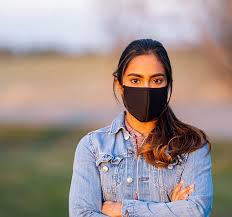

In [4]:
Image.open(io.BytesIO(open('mask1.jfif','rb').read())).convert("RGB")

In [127]:
resp.

400

In [40]:
resp = requests.post("http://127.0.0.1:5000/predict",
                     files={"file": open('maksssksksss14.png','rb')})

In [119]:
resp = requests.post("https://master-ugatit-kmswlee.endpoint.ainize.ai/selfie2anime",
                     files={"file": open('maksssksksss140.png','rb')})


<Response [200]>

In [121]:
resp.headers

{'content-type': 'application/json', 'content-length': '44', 'server': 'istio-envoy', 'date': 'Wed, 16 Dec 2020 15:49:19 GMT', 'x-envoy-upstream-service-time': '2'}

In [96]:
import os

In [79]:
Image.open('maksssksksss14.png')

PIL.PngImagePlugin.PngImageFile

In [99]:
resp.content

b'{"message":"only support jpeg, jpg or png"}\n'

In [20]:
resp = requests.post("http://127.0.0.1:5000/predict",
                     files={"file": open('mask1.jfif','rb')})

In [9]:
from PIL import Image
import io

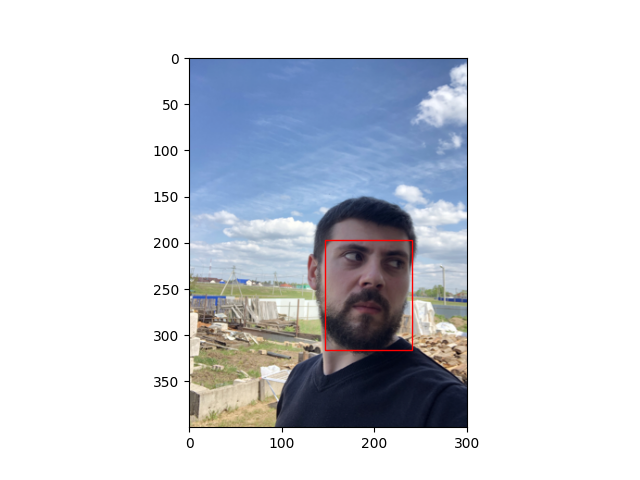

In [55]:
# byte로 전송된 이미지를 복구하는 로직
Image.open(io.BytesIO(resp.content)).convert("RGB")


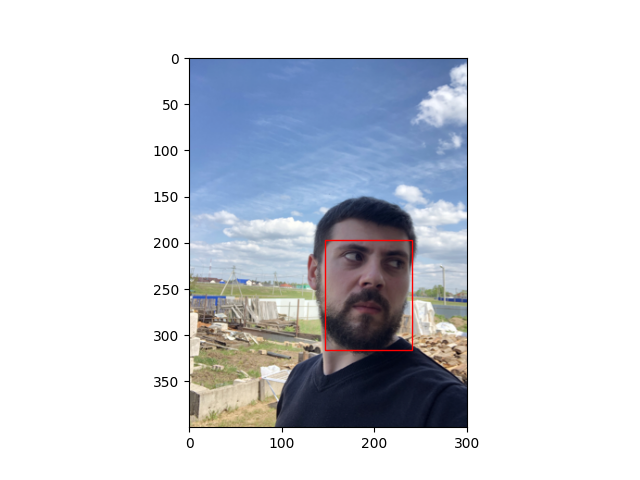

In [46]:
Image.open(io.BytesIO(resp.content)).convert("RGB")


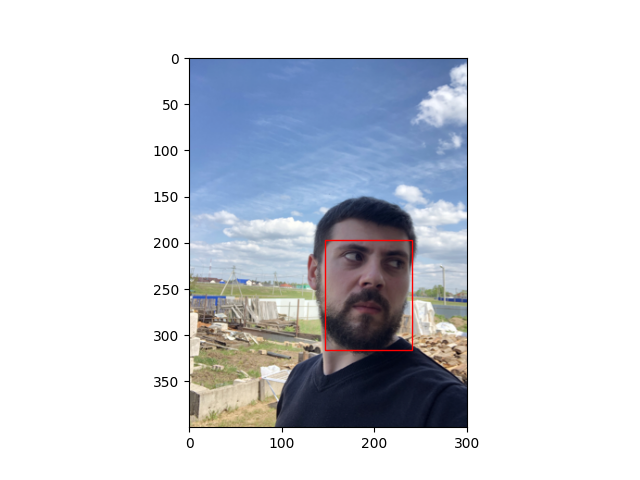

In [42]:
Image.open(io.BytesIO(resp.content)).convert("RGB")
